In [1]:
from scipy.io import loadmat
from matplotlib import pyplot as plt
import nibabel as nib
import torch

import time

from Network import *
from Loss import *
from NeuralODE import *
from Utils import *


/mnt/vol6t/miniconda/envs/vxm_group/lib/python3.9/site-packages/tqdm-4.64.1-py3.9.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [74]:
data = loadmat('data/MAVI101_20160404_pre1.mat')['v']
print(data.shape)
img_size = 256
data[100:100+img_size,50:50+img_size,1,8].shape

(448, 448, 3, 11)


(256, 256)

(448, 448, 3, 11)


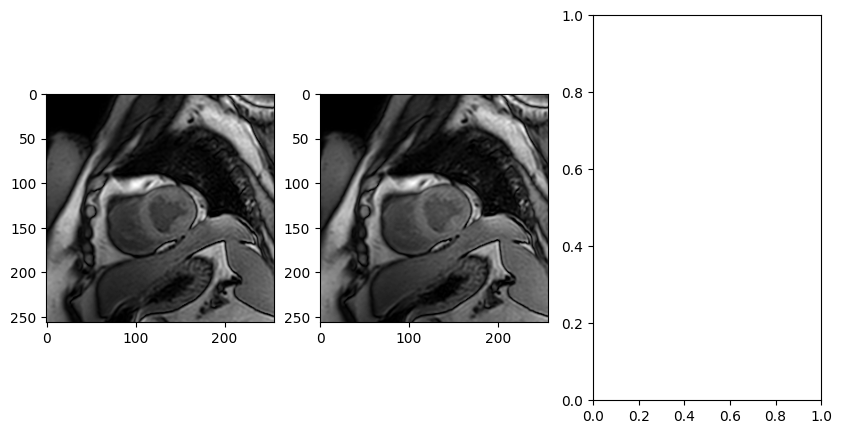

In [130]:
data = loadmat('data/MAVI101_20160404_pre1.mat')['v']
print(data.shape)
img_size = 256
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for i in range(2):
    axs[i].imshow(data[100:100+img_size,50:50+img_size,1,3*i+5],cmap='gray')


In [3]:
moving.shape

NameError: name 'moving' is not defined

torch.Size([1, 2, 256, 256])


/mnt/vol6t/miniconda/envs/vxm_group/lib/python3.9/site-packages/torch-1.13.1-py3.9-linux-x86_64.egg/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


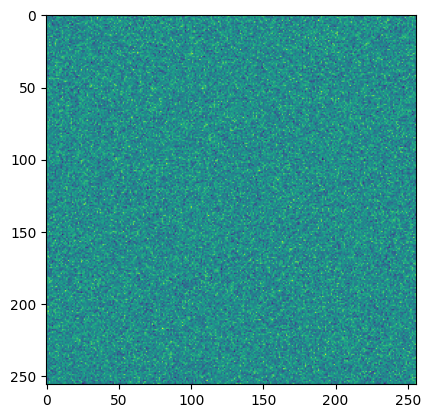

In [4]:
x = torch.randn([1,2,256,256])
moving = data[100:100+img_size,50:50+img_size,1,8]
fixed = data[100:100+img_size,50:50+img_size,1,9]
moving = torch.from_numpy(moving.astype('float')).float()
fixed = torch.from_numpy(fixed.astype('float')).float()
moving = moving.unsqueeze(0).unsqueeze(0)
fixed = fixed.unsqueeze(0).unsqueeze(0)
im_shape = x.shape[2:]
Network = Net2D(img_sz=[256,256],smoothing_kernel='AK', smoothing_win = 12, smoothing_pass = 1, ds=2, bs = 16)
Network(x).shape
plt.imshow(x[0,0,:,:].detach().numpy())


torch.Size([1, 2, 256, 256])


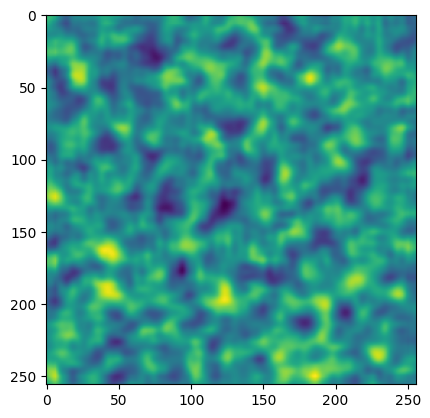

In [5]:
plt.imshow(Network(x)[0,0,:,:].detach().numpy())

In [6]:
ode_train = NeuralODE(Network, 'Euler', 0.0001)


In [7]:
scale_factor = torch.tensor(im_shape).view(1, 2, 1, 1) * 1.


In [8]:
grid = generate_grid2D_tensor(im_shape).unsqueeze(0) # [-1,1]


/mnt/vol6t/miniconda/envs/vxm_group/lib/python3.9/site-packages/torch-1.13.1-py3.9-linux-x86_64.egg/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
ST = SpatialTransformer(im_shape)

In [10]:
optimizer = torch.optim.Adam(ode_train.parameters(), lr=1e-3, amsgrad=True)

In [23]:
loss_NCC = NCC_vxm()

In [24]:
all_phi = ode_train(grid, Tensor(np.arange(2)), return_whole_sequence=True)

torch.Size([1, 2, 256, 256])
f(z) has a shape of torch.Size([1, 2, 256, 256])
z has a shape of torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])


In [25]:
phi = all_phi[-1]

In [26]:
grid_voxel = (grid + 1.) / 2. * scale_factor  # [-1, 1] -> voxel spacing

In [27]:
df = phi - grid_voxel  # with grid -> without grid


In [28]:
warped_moving, df_with_grid = ST(moving, df, return_phi=True)

(-0.5, 255.5, 255.5, -0.5)

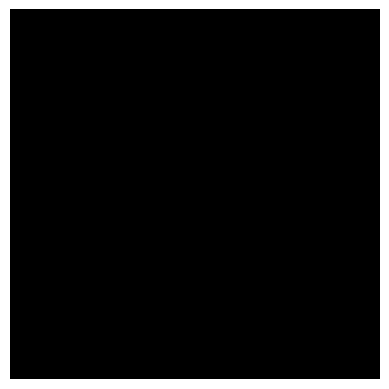

In [29]:
plt.imshow(warped_moving[0,0,:,:].detach().numpy(),cmap='gray')
plt.axis('off')

In [30]:
loss_sim = loss_NCC.loss(fixed,warped_moving)

In [36]:
all_v = all_phi[1:] - all_phi[:-1]

In [59]:
J = df_with_grid
J = J + 1
J = J / 2.
scale_factor = torch.tensor([J.size(1), J.size(2)]).to(J).view(1, 1, 1, 2) * 1.
J = J * scale_factor
dy = J[:, 1:, :-1, :] - J[:, :-1, :-1, :]
dx = J[:, :-1, 1:, :] - J[:, :-1, :-1, :]
detj = dx[..., 0] * dy[..., 1] - dy[..., 0] * dx[..., 1]

In [61]:
detj.shape

torch.Size([1, 255, 255])

In [49]:
dy.shape

torch.Size([1, 255, 255, 2])

In [151]:
fixed = nib.load('./data/OAS1_0001_MR1/brain.nii.gz')
moving = nib.load('./data/OAS1_0002_MR1/brain.nii.gz')
registered = nib.load('./result_2D/warped.nii.gz')
X = nib.load('./result_2D/df_grid.nii.gz')

In [113]:
label = nib.load('./data/OAS1_0001_MR1/brain_aseg.nii.gz')

In [114]:
label.get_fdata().min()

0.0

In [152]:
fixed = fixed.get_fdata()
moving = moving.get_fdata()
registered = registered.get_fdata()
X = X.get_fdata()


In [153]:
int(11/2), 11//2

(5, 5)

In [156]:
img_list = [fixed, moving, registered, X]

IndexError: index 80 is out of bounds for axis 2 with size 1

<Figure size 2000x500 with 0 Axes>

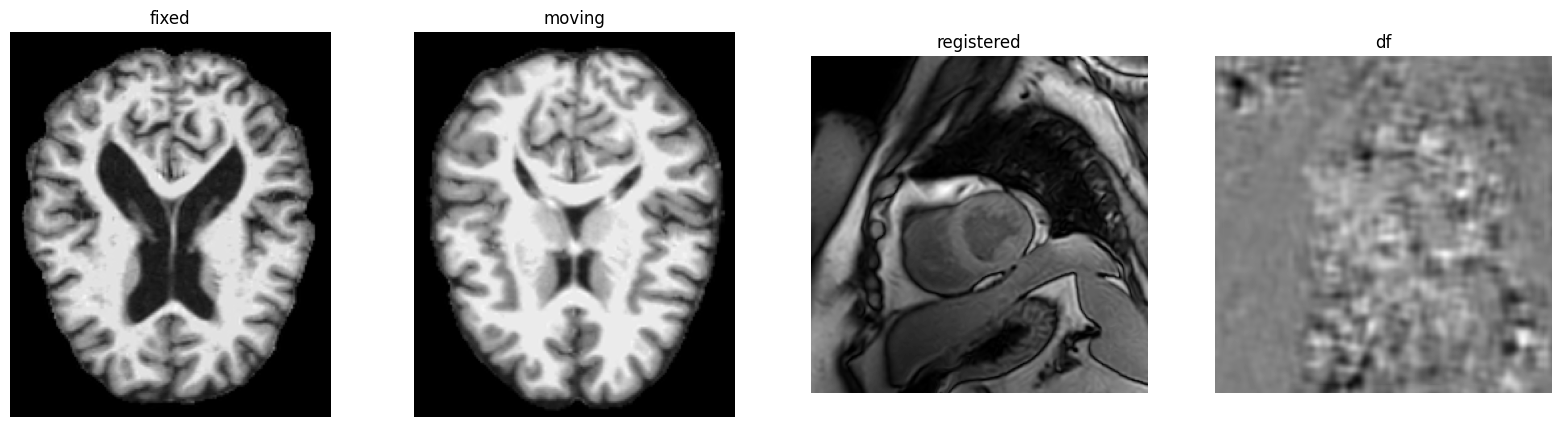

In [157]:
plt.figure(figsize=(20,5))
fig, axs = plt.subplots(1,4,figsize=(20,5))
for i in range(4):
    if i == 3:
        axs[i].imshow(img_list[i][:,:,:,1], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(['fixed', 'moving', 'registered', 'df'][i])
    if i == 2:
        axs[i].imshow(img_list[i][:,:], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(['fixed', 'moving', 'registered', 'df'][i])
    else:
        axs[i].imshow(img_list[i][:,:,80].transpose(1,0), cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(['fixed', 'moving', 'registered', 'X'][i])


(448, 448, 3, 11)


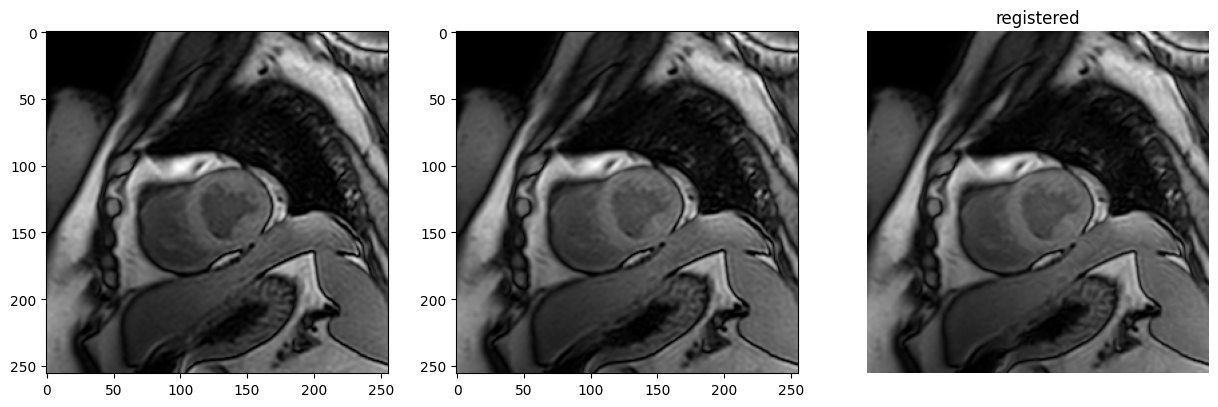

In [158]:
data = loadmat('data/MAVI101_20160404_pre1.mat')['v']
print(data.shape)
img_size = 256
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    if i == 2:
        axs[i].imshow(img_list[i][:,:], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(['fixed', 'moving', 'registered', 'df'][i])
        continue
    else:
        axs[i].imshow(data[100:100+img_size,50:50+img_size,1,i*3+5],cmap='gray')